# Model-Based Collaborative Filtering - Matrix Factorization

### Explicit Data
- 점수, 후기 등 사용자가 자신의 선호를 직접적으로 데이터입니다.

### Impicit Data
- 장바구니 기록, 시청 횟수 등 사용자가 자신의 선호를 직접적으로 드러내지 않은 데이터입니다.
- 따라서 사용자는 자신이 선호하는 아이템에 대해서 주로 로그를 발생시킨다고 가정하여 접근합니다.
- 주로 긍정적 반응이 기록된다는 특징이 있습니다.
- 사용자의 행동에 따라 자동으로 기록되므로 explicit data보다 dense합니다.
- 도메인 지식을 활용하여 경험적으로 접근하며 시행착오를 겪어야 합니다.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import tensorflow as tf
from google_drive_downloader import GoogleDriveDownloader as gdd

np.set_printoptions(3)

## Last.fm 데이터
- `player_df` : 각 유저의 아티스트별 재생 횟수 (상호작용 데이터)
- `artist_df` : 아티스트 정보 (아이템에 대한 데이터)
- `user_df` : 유저 정보 (사용자에 대한 데이터)

In [3]:
gdd.download_file_from_google_drive(file_id="1BpEbW6iSUlIp7zr3s_KDaeIRMUjgpSlV", dest_path="./plays.csv")
plays_df = pd.read_csv("plays.csv")

gdd.download_file_from_google_drive(file_id="1vxEhaNO6FhK96nWXiJCgs4JbjNCE4Kf1", dest_path="./artists.csv")
arts_df = pd.read_csv("artists.csv")

gdd.download_file_from_google_drive(file_id="1cebHz1STTTNJiHt9wLA1tdJjocSVR1B6", dest_path="./users.csv")
users_df = pd.read_csv("users.csv")

In [4]:
plays_df.sample(5)

,user_id,artist_id,plays
5914175,122783,5541,611
4820063,100105,688,174
14263910,296126,23181,36
13054360,271024,8319,225
14550422,302060,552,53


In [5]:
plays_df.shape

(17302623, 3)

In [6]:
users_df.sample(5)

,user_id,gender,age,country
40714,40714,m,19,Russian Federation
67718,67718,m,-1,United States
50688,50688,m,-1,United States
67231,67231,m,-1,United States
114371,114371,m,25,United States


In [7]:
users_df.shape

(359347, 4)

In [8]:
arts_df.sample(5)

,artist_id,artist_name
82117,82117,return of the red
137775,137775,secret ingredients
65693,65693,montreal jazz club
125468,125468,nåid
123428,123428,jurek raben


In [9]:
arts_df.shape

(160110, 2)

In [10]:
# 사용자별 1곡 이상 들은 아티스트의 수
n_arts_df = plays_df.groupby(["user_id"]).size().rename("n_arts")

In [11]:
n_arts_df.sample(5)

user_id
263063    47
229281    49
350327    53
9305      41
186306    46
Name: n_arts, dtype: int64

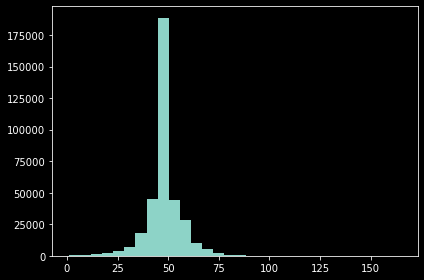

In [12]:
plt.style.use("dark_background")

fig, ax = plt.subplots()

ax.hist(n_arts_df, bins=30)

fig.tight_layout()

- 약 50개의 곡을 평균으로 한 정규분포에 가까운 형태를 보입니다.

In [13]:
# 아티스트별 자신의 음악을 들은 사용자의 수
n_users_df = plays_df.groupby(["artist_id"]).size().rename("n_users")

In [14]:
n_users_df.sample(5)

artist_id
58794       4
16659     429
16933      30
129996      2
136034      3
Name: n_users, dtype: int64

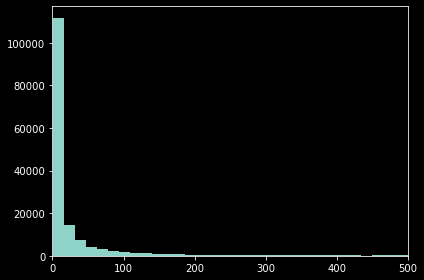

In [15]:
fig, ax = plt.subplots()

ax.hist(n_users_df, bins=5000)
ax.set_xlim([0, 500])

fig.tight_layout()

- 파레토 분포에 가까운 형태를 보입니다.

In [16]:
# 사용자별 아티스트당 평균 재생 횟수
mn_plays_df = plays_df.groupby(["user_id"]).mean()["plays"]

In [112]:
mn_plays_df.sample(5)

user_id
58319      33.377049
265113    519.519231
268097    253.291667
120395     39.434783
27439      11.580000
Name: plays, dtype: float64

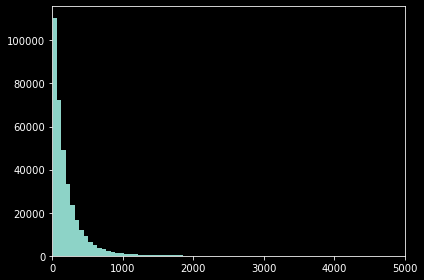

In [119]:
fig, ax = plt.subplots()

ax.hist(mn_plays_df, bins=1000)
ax.set_xlim([0, 5000])

fig.tight_layout()

### Embedding
- 사용자의 취향과 아이템의 특성을 벡터로 변환할 수 있다면 서로 간의 유사도를 계산할 수 있습니다.
- 이렇게 의미를 정확히 알 수 없는 숫자들의 조합으로 표현하는 것을 embedding이라고 합니다.

### Matrix Factorization
- 사용자의 각 아이템에 대한 선호를 나타낸 행렬로부터 사용자의 취향을 나타낸 행렬과 제품의 특성을 나타낸 행렬로 분해하는 것을 말합니다.
<img src="https://i.imgur.com/zvx2JNs.png" height="150" width="400" >
- 이를 통해 다음이 가능해짐.
    - Rating Prediction : 사용자가 아직 선호를 나타내지 않은 아이템에 대한 선호를 예측할 수 있습니다.
    - User Clustering : 유사한 취향을 가진 사용자끼리 군집화가 가능합니다..
    - Item Clustering : 유사한 특성을 가진 아이템끼리 군집화가 가능합니다..
    
### Memory-Based Collaborative Filtering과 Model-Based Collaborative Filtering의 차이

#### Memory-Based Collaborative Filtering
- 별도의 특성 추출 과정 없이 사용자의 아이템에 대한 선호 데이터를 바로 사용합니다.
- 비교적 직관적이나 뻔한 추천을 할 가능성이 존재한다는 단점이 있습니다.

#### Model-Based Collaborative Filtering
- 특성을 추출하여 embedding vector를 생성하는 과정이 필요합니다.
- 좀 더 다양한 형태의 추천 가능합니다.